In [1]:
from readin import *

ms3data = readin("proteinGroups_MS3_simplified.txt")

C:\Users\M McCown\Jupyter\readin.py:96: RuntimeWarning: divide by zero encountered in log
  dfl = (np.log(df)).replace(-np.inf, 0)


<Figure size 1000x700 with 1 Axes>

<Figure size 1000x700 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1000x700 with 1 Axes>

In [2]:
leastValue = np.nanmin(ms3data.replace(0, np.nan).values)

# Variance Between Cell Lines

In [3]:
technical_replicates = {
    "Cell Line 1":[0,1,2],
    "Cell Line 2":[3,4,5],
    "Cell Line 3":[6,8],
    
    "Cell Line 4":[10,11,12],
    "Cell Line 5":[13,14,15],
    "Cell Line 6":[16,18]
}

ms3Samples = {}
sample_aves = {}
leastValue = np.inf

for sample in technical_replicates:
    #
    reps = {}
    sample_proteins = {}
    for rep in technical_replicates[sample]:
        reps[ms3data.iloc[:,rep].name] = ms3data.iloc[:,rep]
    ms3Samples[sample] = pd.DataFrame.from_dict(reps, dtype = float)
        
    for r in range(0, len(list(reps.values())[0])):
        rep_for_protein = []
        p = ms3data.iloc[r].name
        for rep in reps.values():
            if rep[r] > 0: rep_for_protein.append(rep[r])
            if rep[r] > 0.0 and rep[r] < leastValue: leastValue=rep[r]
        if len(rep_for_protein) > 1: 
            sample_proteins[p] = mean(rep_for_protein)
        else: sample_proteins[p] = 0.0
    sample_aves[sample] = sample_proteins
sample_aves = pd.DataFrame.from_dict(sample_aves, dtype = float)

sample_names = []
for i in sample_aves:
    sample_names.append(i)

In [4]:
print(leastValue)

3.047802765844993


##### These are the same loops as below, to compare all lines to all lines without duplicates
for i in range(0,len(sample_names)-1):

    for o_ser_index in range(i+1,len(sample_names)):

        print (i, o_ser_index)

In [5]:
h = ms3data.shape[0]
variances = {}
var_flat = np.empty(shape = (h*15))
fold_changes = {}
flat_index = 0

for ser_index in range(0,len(sample_names)-1): #these are the keys to ms3Samples
    ser = sample_names[ser_index]
    sample_df1 = ms3Samples[ser]
    for o_ser_index in range(ser_index+1,len(sample_names)): #keys again
        o_ser = sample_names[o_ser_index]
        #compare variance in sample versus otherSample
        sample_df2 = ms3Samples[o_ser]
        for protein in sample_df1.index:
            t1 = [x for x in sample_df1.loc[protein,:] if x != 0]
            t2 = [x for x in sample_df2.loc[protein,:] if x != 0]
            if len(t1) > 1: v1 = variance(t1)
            else: v1 = 0
            if len(t2) > 1: v2 = variance(t2)
            else: v2 = 0
            v = (v1+v2)/2
            variances[((ser,o_ser),protein)] = v
            #this needs to implement the half-least-psuedo-zero to avoid divided by zero errors
            m2 =skipZeroMean(t2); m1 = skipZeroMean(t1)
            if m1 ==0: m1 = leastValue/2
            if m2 ==0: m2 = leastValue/2
            fold_changes[((ser,o_ser),protein)] = m2/m1
            var_flat[flat_index]=v
            flat_index +=1

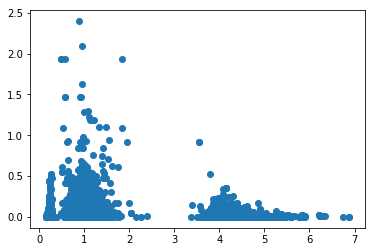

In [6]:
#Volcano Graph
plt.scatter(fold_changes.values(), variances.values())
plt.show()

##### Log-Normalized Technical Variance Thresholds
###### Ignoring Zeros: 
###### 95% threshold:  0.2601427941399485
###### 99% threshold:  0.5243715339788084

In [7]:
#Log-Normalized Technical Variance Thresholds, Ignoring Zeros: 
threshold95 = 0.2601427941399485
threshold99 = 0.5243715339788084

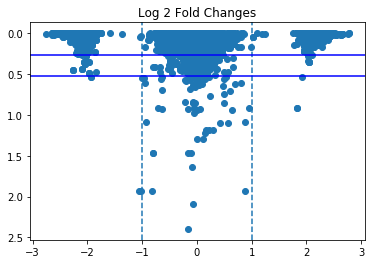

In [8]:
#Volcano Graph
plt.title("Log 2 Fold Changes")
log2_fold_changes = [math.log2(x) for x in fold_changes.values()]
plt.scatter(log2_fold_changes, variances.values())
plt.axvline(x=1, linestyle='dashed')
plt.axvline(x=-1, linestyle='dashed')
plt.axhline(y=threshold95, color='b', linestyle='-')
plt.axhline(y=threshold99, color='b', linestyle='-')
plt.gca().invert_yaxis()
plt.show()

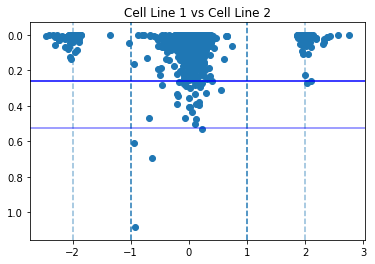

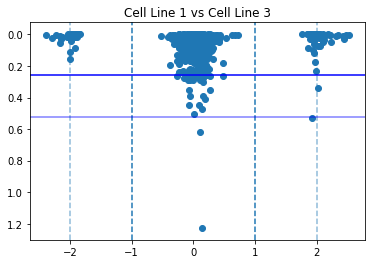

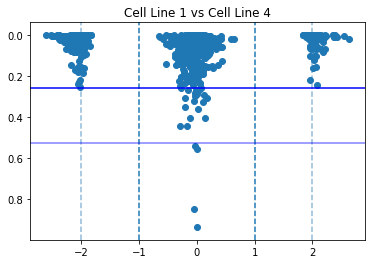

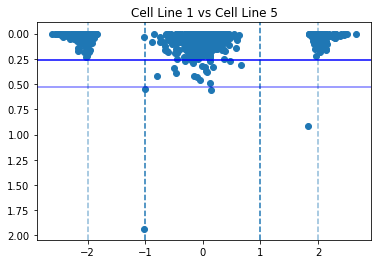

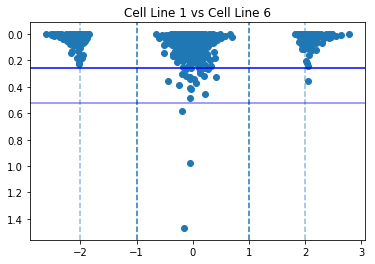

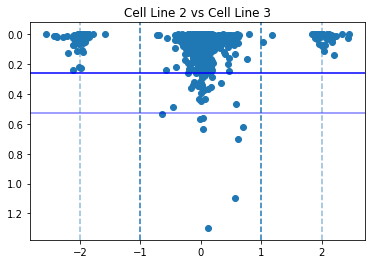

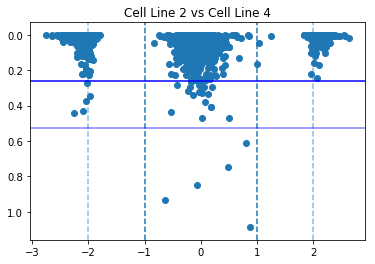

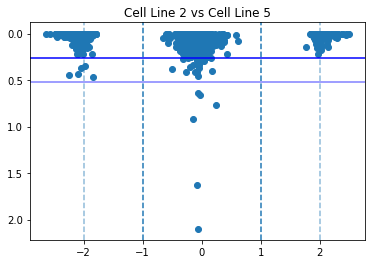

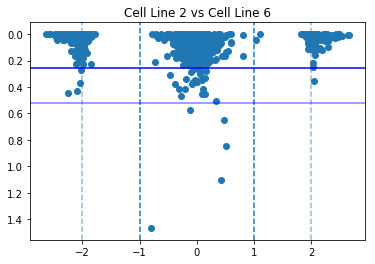

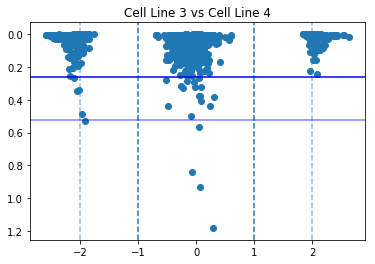

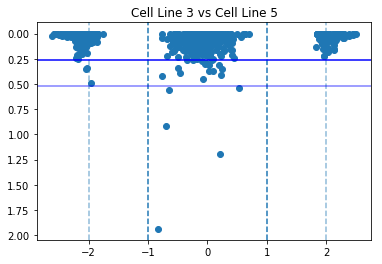

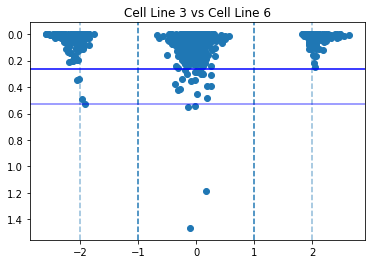

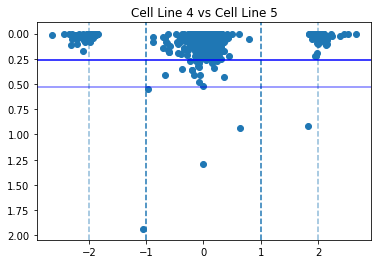

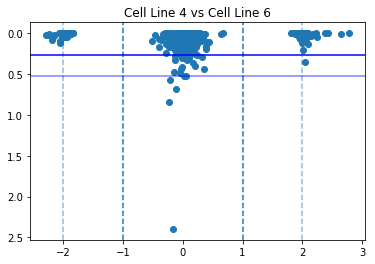

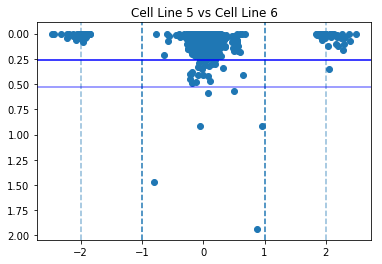

In [10]:
lines_to_comp = []
for ser_index in range(0,len(sample_names)-1): 
    ser = sample_names[ser_index]
    for o_ser_index in range(ser_index+1,len(sample_names)):
        o_ser = sample_names[o_ser_index]
        lines_to_comp.append((ser,o_ser))
        plt.title(ser+" vs "+o_ser)
        svo_fc = {x:fold_changes[x] for x in fold_changes if x[0] == (ser,o_ser)}
        svo_var = {x:variances[x] for x in variances if x[0] == (ser,o_ser)}
        
        log2_fold_changes = [math.log2(x) for x in svo_fc.values()]
        plt.scatter(log2_fold_changes, svo_var.values())
        
        plt.axvline(x=  1, linestyle='dashed')
        plt.axvline(x= -1, linestyle='dashed')
        plt.axvline(x=  2, linestyle='dashed', alpha=.5)
        plt.axvline(x= -2, linestyle='dashed', alpha=.5)
        plt.axhline(y=threshold95, color='b', linestyle='-')
        plt.axhline(y=threshold99, color='b', alpha=.5, linestyle='-')
        plt.gca().invert_yaxis()

        plt.show()
        
       

In [15]:
weirdpoints = []
#print("\nCell Lines Compared\t\t\tProtein\t\t  Fold Change\t\t Variance\n")
for key in fold_changes:
    if abs(math.log2(fold_changes[key])) > 1:
        if variances[key] < threshold95:
            weirdpoints.append(key)
            #print (key[0][0], 'vs',key[0][1], '\t', key[1],"\t{0:.4f}".format(math.log2(fold_changes[key])),"\t{0:.4f}".format(variances[key]))

548 proteins change significantly at least once, out of 1436 (38.16%))
4068 points change significantly out of 21540 (18.89%))


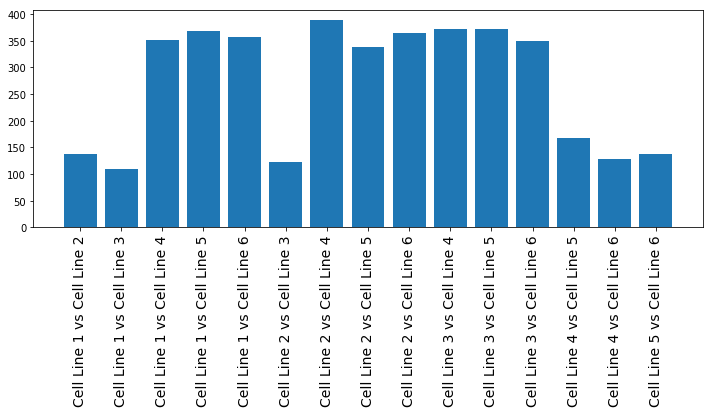

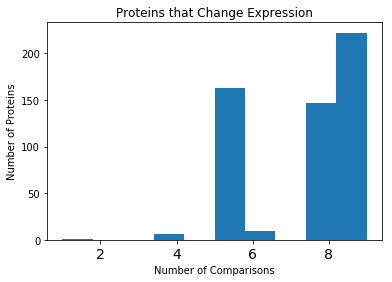

In [16]:
line_category_counts = {}#Example key = "Cell Line1 vs Cell line 2" value = number of occurances
protein_category_counts = {}#Name:Frequency
for key in weirdpoints:
    line_category = (key[0][0]+" vs "+key[0][1])
    if line_category in line_category_counts:
        line_category_counts[line_category] += 1
    else: line_category_counts[line_category] = 1
    
    protein = key[1]
    if protein in protein_category_counts:
        protein_category_counts[protein] += 1
    else:protein_category_counts[protein] = 1
        
print ("{0} proteins change significantly at least once, out of {1} ({2:.2f}%))"
       .format(len(protein_category_counts), ms3data.shape[0], len(protein_category_counts)/ms3data.shape[0]*100))
print ("{0} points change significantly out of {1} ({2:.2f}%))"
       .format((len(weirdpoints)), len(variances.values()), (len(weirdpoints))/(len(variances.values()))*100))

plt.figure(figsize=(12,4))
plt.rc('xtick', labelsize=14) 
plt.bar(range(len(line_category_counts)), list(line_category_counts.values()), align='center')
plt.xticks(range(len(line_category_counts)), list(line_category_counts.keys()), rotation="vertical")
plt.show()

plt.hist(protein_category_counts.values())
plt.title("Proteins that Change Expression")
plt.xlabel("Number of Comparisons")
plt.ylabel("Number of Proteins")
plt.show()

In [ ]:
for i in protein_category_counts:
    print (i,'\t',protein_category_counts[i])

In [ ]:
# Are the proteins up or down regulated consistently?

up_reg_points = []
down_reg_points = []
for key in weirdpoints:
    if fold_changes[key] > 1: up_reg_points.append(key)
    if fold_changes[key] < 1: down_reg_points.append(key)
print (len(weirdpoints))
print (len(up_reg_points))
print (len(down_reg_points))

In [ ]:
line_category_counts = {}#Example key = "Cell Line1 vs Cell line 2" value = number of occurances
protein_category_counts = {}#Name:Frequency
for key in up_reg_points:
    line_category = (key[0][0]+" vs "+key[0][1])
    if line_category in line_category_counts:
        line_category_counts[line_category] += 1
    else: line_category_counts[line_category] = 1
    
    protein = key[1]
    if protein in protein_category_counts:
        protein_category_counts[protein] += 1
    else:protein_category_counts[protein] = 1

print ("{0} proteins change significantly at least once, out of {1} ({2:.2f}%))"
       .format(len(protein_category_counts), ms3data.shape[0], len(protein_category_counts)/ms3data.shape[0]*100))
print ("{0} points are upregulated, out of {1} ({2:.2f}%))"
       .format((len(up_reg_points)), len(variances.values()), (len(up_reg_points))/(len(variances.values()))*100))

plt.figure(figsize=(12,4))
plt.title("Upregulated Data Points")
plt.ylabel("Number of Proteins")
plt.rc('xtick', labelsize=14) 
plt.bar(range(len(line_category_counts)), list(line_category_counts.values()), align='center')
plt.xticks(range(len(line_category_counts)), list(line_category_counts.keys()), rotation="vertical")
plt.show()

plt.hist(protein_category_counts.values())
plt.title("Upregulated Proteins")
plt.xlabel("Number of Comparisons")
plt.ylabel("Number of Proteins")
plt.show()

In [ ]:
line_category_counts = {}#Example key = "Cell Line1 vs Cell line 2" value = number of occurances
protein_category_counts = {}#Name:Frequency
for key in down_reg_points:
    line_category = (key[0][0]+" vs "+key[0][1])
    if line_category in line_category_counts:
        line_category_counts[line_category] += 1
    else: line_category_counts[line_category] = 1
    
    protein = key[1]
    if protein in protein_category_counts:
        protein_category_counts[protein] += 1
    else:protein_category_counts[protein] = 1
        
print ("{0} proteins change significantly at least once, out of {1} ({2:.2f}%))"
       .format(len(protein_category_counts), ms3data.shape[0], len(protein_category_counts)/ms3data.shape[0]*100))
print ("{0} points are down regulated, out of {1} ({2:.2f}%))"
       .format((len(down_reg_points)), len(variances.values()), (len(down_reg_points))/(len(variances.values()))*100))

plt.figure(figsize=(12,4))        
plt.rc('xtick', labelsize=14) 
plt.title("Downregulated Proteins")
plt.bar(range(len(line_category_counts)), list(line_category_counts.values()), align='center')
plt.xticks(range(len(line_category_counts)), list(line_category_counts.keys()), rotation="vertical")
plt.show()

plt.hist(protein_category_counts.values())
plt.title("Downregulated Proteins")
plt.xlabel("Number of Comparisons")
plt.ylabel("Number of Proteins")
plt.show()